# Library and Dataset Imports

In [1]:
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import time
import datetime
import matplotlib.image as mpimg
import cv2
import gc
import psutil
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.corpus import wordnet as wn

import pandas as pd
import io
import numpy as np
import os

from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn import metrics
from sklearn import utils
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import VotingClassifier

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional, SimpleRNN 
from keras.utils import to_categorical
from keras.regularizers import l2

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, SimpleRNN, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from collections import defaultdict

from __future__ import absolute_import, division, print_function

start = datetime.datetime.now()

stop_words = set(stopwords.words('english'))

target_numbers = {'Positive': 7000, 'Neutral': 7000, 'Negative': 7000}

lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

outputDir = 'C:\\Users\\Owner\\OneDrive\\Desktop\\My Computer\\AI\\Master of Science in Artificial Intelligence [Taught and Research (Mainly by Research)]\\ICS5200 Dissertation\\Result Screenshots\\Subplots\\'

def clean_email_text(email_text):
    pattern = r"Message-ID.*Content-Transfer-Encoding: 7bit"
    email_text = re.sub(pattern, "", email_text, flags=re.DOTALL)
    lines = email_text.split("\n")
    res = []
    for line in lines:
        if "X-" not in line:
            line.replace("\t"," ")
            res.append(line)
    return " ".join(res)


def replace_empty_string_with_Null(text):
    if text == "":
        return None
    return text


def remove_punctuations_and_special_characters(text):
    return re.sub(r'[^\w\s]','',text)


def preprocessing_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)


def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"RSS (Resident Set Size) Memory Used by Process: {mem_info.rss / 1024 ** 2:.2f} MB")

In [2]:

# Enron
print("Importing Enron dataset...", end =" "),
data = pd.read_csv("./Datasets/emails.csv")
print("done!")

# Twitter
print("Importing Twitter dataset...", end =" "),
dataset = pd.read_csv("./Datasets/train.csv", encoding='unicode_escape')
print("done!")

# Number of rows to drop
n = 400000

print("Removing extra ", n, "rows from Enron dataset...", end =" "),
# Dropping last n rows using drop
data.drop(data.tail(n).index,
        inplace = True)
print("done!")

# data.count()

Importing Enron dataset... done!
Importing Twitter dataset... done!
Removing extra  400000 rows from Enron dataset... done!


## Applying Helper Functions

In [3]:
%%time

# Text preprocessing
print("Preprocessing Enron text...", end =" "),
data["processed_message"] = data['message'].apply(clean_email_text)
data.processed_message = data.processed_message.apply(replace_empty_string_with_Null)
null_values = data.processed_message.isnull()
data.dropna(subset=['processed_message'], inplace = True)
data.processed_message = data.processed_message.apply(lambda x: remove_punctuations_and_special_characters(x))
data.processed_message = data.processed_message.apply(preprocessing_text)
print("done!")

#Sentiment labelling
print("Labelling the Enron messages with sentiments using the VADER Sentiment Analyzer...", end =" "),
data["vader_intensity"] = data["processed_message"].apply(get_vader_sentiment)
print("done!")

# Sentiment mapping
print("Mapping sentiment values...", end =" "),
data["vader_sentiment"] = data["vader_intensity"].apply(lambda x: "Positive" if x>0 else "Negative" if x<0 else "Neutral")
print("done!")

# Compiling dataset.
print("Compiling final dataset...", end =" "),
data = data[['processed_message', 'vader_sentiment']]
print("done!")

print()

difference = 7000
# difference = 9000

# Calculating extra rows to be removed.
posDiff = (data[data.vader_sentiment == 'Positive'].shape[0]) - difference
negDiff = (data[data.vader_sentiment == 'Negative'].shape[0]) - difference
neuDiff = (data[data.vader_sentiment == 'Neutral'].shape[0]) - difference

print("Rows to be removed from Enron dataset:")
print("Enron Neutral Sentiment entries : ", data[data.vader_sentiment == 'Neutral'].shape[0], " rows, with ", neuDiff, " rows to remove.")
print("Enron Positive Sentiment entries: ", data[data.vader_sentiment == 'Positive'].shape[0], "rows, with ", posDiff, " rows to remove.")
print("Enron Negative Sentiment entries: ", data[data.vader_sentiment == 'Negative'].shape[0], "rows, with ", negDiff, " rows to remove.")

print()

# Function to drop rows based on sorted index
def drop_excess_rows(df, sentiment, excess_count):
    if excess_count > 0:
        # Sort the DataFrame by index
        sorted_df = df[df['vader_sentiment'] == sentiment].sort_index()
        # Drop the excess rows
        df = df.drop(sorted_df.index[:excess_count])
    return df

# Remove extra rows for each sentiment category
data = drop_excess_rows(data, 'Neutral', neuDiff)
data = drop_excess_rows(data, 'Positive', posDiff)
data = drop_excess_rows(data, 'Negative', negDiff)

print("Updated Enron Neutral Sentiment entries : ", data[data.vader_sentiment == 'Neutral'].shape[0])
print("Updated Enron Positive Sentiment entries: ", data[data.vader_sentiment == 'Positive'].shape[0])
print("Updated Enron Negative Sentiment entries: ", data[data.vader_sentiment == 'Negative'].shape[0])

Preprocessing Enron text... done!
Labelling the Enron messages with sentiments using the VADER Sentiment Analyzer... done!
Mapping sentiment values... done!
Compiling final dataset... done!

Rows to be removed from Enron dataset:
Enron Neutral Sentiment entries :  12567  rows, with  5567  rows to remove.
Enron Positive Sentiment entries:  95256 rows, with  88256  rows to remove.
Enron Negative Sentiment entries:  9576 rows, with  2576  rows to remove.

Updated Enron Neutral Sentiment entries :  7000
Updated Enron Positive Sentiment entries:  7000
Updated Enron Negative Sentiment entries:  7000
CPU times: total: 3min 48s
Wall time: 8min 23s


# Enron Classification

## Enron Logistic Regression

In [ ]:
%%time

X = data['processed_message']
y = data['vader_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_cv, y_train)

# transform X_test using CV
X_test_cv = cv.transform(X_test)

# generate predictions
predictions = lr.predict(X_test_cv)

y_test_cv = cv.transform(y_test)

report11 = classification_report(y_test, predictions)

print(report11)

lrAccEnron = accuracy_score(y_test, predictions)
print("Enron Logistic Regression Classification Accuracy Score: ", lrAccEnron)

print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision11 = [float(x.split()[1]) for x in report11.split('\n')[2:5]]
recall11 = [float(x.split()[2]) for x in report11.split('\n')[2:5]]
f1_score11 = [float(x.split()[3]) for x in report11.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))
ax.bar(bar_positions, precision11, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall11, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score11, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Logistic Regression Classification Report Metrics')
ax.legend()

plt.savefig(outputDir + '\\Enron\\EnronLogisticRegression.png')

plt.show()

In [ ]:
import gc
gc.collect()

## Enron Naive Bayes Multinomial Classifier

In [ ]:
%%time

# X = data['processed_message']
# y = data['vader_sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

cv = CountVectorizer()
cv_train  = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

Naive = naive_bayes.MultinomialNB()

Naive.fit(X_train_cv, y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(cv_test)

y_test_cv = cv.transform(y_test)

report12 = classification_report(y_test, predictions_NB)

naive_bayesAccEnron = accuracy_score(y_test, predictions_NB)
print("Enron Naive Bayes Multinomial Classification Accuracy Score: ", naive_bayesAccEnron)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

print(report12)

# Extract precision, recall, and f1-score from the classification report
precision12 = [float(x.split()[1]) for x in report12.split('\n')[2:5]]
recall12 = [float(x.split()[2]) for x in report12.split('\n')[2:5]]
f1_score12 = [float(x.split()[3]) for x in report12.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision12, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall12, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score12, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Naive Bayes Classification Report Metrics')
ax.legend()

plt.savefig(outputDir + '\\Enron\\EnronNaiveBayes.png')

plt.show()

## Enron Support Vector Machine Classifier

In [ ]:
%%time

# Initialize CountVectorizer
cv = CountVectorizer()

# X = data['processed_message']
# y = data['vader_sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Fit CountVectorizer and transform the training data
X_train_cv = cv.fit_transform(X_train)

# Transform the test data
X_test_cv = cv.transform(X_test)

# Create an SVM Classifier
clf = svm.SVC(kernel='linear')  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train_cv, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test_cv)

report13 = classification_report(y_test, y_pred)

svmAccEnron = accuracy_score(y_test, y_pred)
print("Enron Support Vector Machine Classification Accuracy Score: ", svmAccEnron)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

print(report13)

# Extract precision, recall, and f1-score from the classification report
precision13 = [float(x.split()[1]) for x in report13.split('\n')[2:5]]
recall13 = [float(x.split()[2]) for x in report13.split('\n')[2:5]]
f1_score13 = [float(x.split()[3]) for x in report13.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision13, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall13, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score13, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Support Vector Machine Classification Report Metrics')
ax.legend()

plt.savefig(outputDir + '\\Enron\\EnronSVM.png')

plt.show()

## Enron Desicion Tree Classifier

In [ ]:
%%time

cv = CountVectorizer()

X = data['processed_message']
y = data['vader_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Fit CountVectorizer and transform the training data
X_train_cv = cv.fit_transform(X_train)

# Transform the test data
X_test_cv = cv.transform(X_test)

dtc = DecisionTreeClassifier()

# Train Decision Tree Classifier
dtc = dtc.fit(X_train_cv, y_train)

# Predict the response for test dataset
y_pred = dtc.predict(X_test_cv)

report14 = classification_report(y_test, y_pred)

dtcAccEnron = accuracy_score(y_test, y_pred)
print("Enron Decision Tree Classification Accuracy Score: ", dtcAccEnron)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

print(report14)

# Extract precision, recall, and f1-score from the classification report
precision14 = [float(x.split()[1]) for x in report14.split('\n')[2:5]]
recall14 = [float(x.split()[2]) for x in report14.split('\n')[2:5]]
f1_score14 = [float(x.split()[3]) for x in report14.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision14, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall14, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score14, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Decision Tree Classifier Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Enron\\EnronDTC.png')

plt.show()

## Enron MLP Classifier

In [ ]:
%%time

X = data['processed_message']
y = data['vader_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(200, 100),
                        activation='relu',  # Activation function for hidden layers
                        solver='adam',  # Optimization algorithm
                        max_iter=7,  # Maximum number of iterations
                        random_state=42)

mlp_clf.fit(X_train_tfidf, y_train)

# Evaluating the Model
y_pred = mlp_clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)

predictions = mlp_clf.predict(X_test_tfidf)

# Generate the classification report
report15 = classification_report(y_test, predictions)
print(report15)

# Compute accuracy
mlpAcc = accuracy_score(y_test, predictions)
print("MLP Classification Accuracy Score: ", mlpAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision15 = [float(x.split()[1]) for x in report15.split('\n')[2:5]]
recall15 = [float(x.split()[2]) for x in report15.split('\n')[2:5]]
f1_score15 = [float(x.split()[3]) for x in report15.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))
ax.bar(bar_positions, precision15, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall15, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score15, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron MLP Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Enron\\EnronMLP.png')

plt.show()

## Enron LSTM Network Classification

In [ ]:
%%time

# LSTM Neural Network.
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

X = data['processed_message']
y = data['vader_sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Reshape data for LSTM
max_features = X_train_vec.shape[1]
maxlen = X_train_vec.shape[0]

X_train_lstm = X_train_vec.reshape(maxlen, 1, max_features)
X_test_lstm = X_test_vec.reshape(X_test_vec.shape[0], 1, max_features)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define LSTM model with moderate complexity, dropout, and regularization
model = Sequential()
model.add(LSTM(64, input_shape=(1, max_features))),
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
model.add(Dropout(0.5)),
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
model.add(Dropout(0.5)),
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_lstm, y_train_onehot, batch_size=64, epochs=20, 
                    validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracyLSTM = model.evaluate(X_test_lstm, y_test_onehot)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()


# Predict the sentiment classes for the test set
y_pred_prob = model.predict(X_test_lstm)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Enron LSTM Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.legend()

plt.ylim(0, 1.0)

plt.savefig(outputDir + '\\Enron\\EnronLSTM.png')

plt.show()

## Enron ANN Network Classification

D:\Anaconda Download\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │      20,880,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,921,987 (79.81 MB)

 Trainable params: 20,921,987 (79.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5891 - loss: 2.2431 - val_accuracy: 0.8833 - val_loss: 0.8165
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.8889 - loss: 0.8254 - val_accuracy: 0.9060 - val_loss: 0.8360
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9163 - loss: 0.8071 - val_accuracy: 0.9119 - val_loss: 0.8291
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9237 - loss: 0.7948 - val_accuracy: 0.9202 - val_loss: 0.8036
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9342 - loss: 0.7590 - val_accuracy: 0.9226 - val_loss: 0.7610
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9450 - loss: 0.7084 - val_accuracy: 0.9315 - val_loss: 0.7423
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9419 - loss: 0.7115 - val_accuracy: 0.9256 - val_loss: 0.7376
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9535 - loss: 0.6467 - val_accuracy: 0

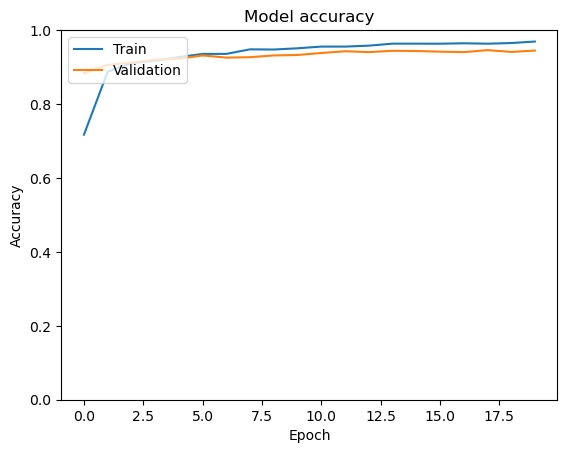

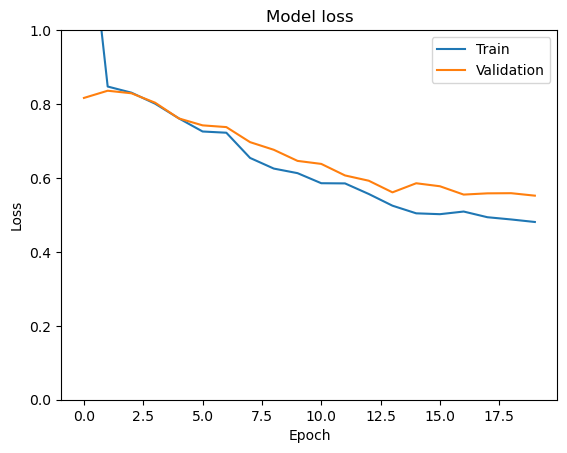

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9505 - loss: 0.5394
Test Loss: 0.5411498546600342
Test Accuracy: 0.9490476250648499
CPU Load     :  1.5
RAM Used (GB): 24.22454272
RSS (Resident Set Size) Memory Used by Process: 16266.06 MB
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.94      1392
     Neutral       0.95      0.96      0.96      1383
    Positive       0.96      0.95      0.96      1425

    accuracy                           0.95      4200
   macro avg       0.95      0.95      0.95      4200
weighted avg       0.95      0.95      0.95      4200



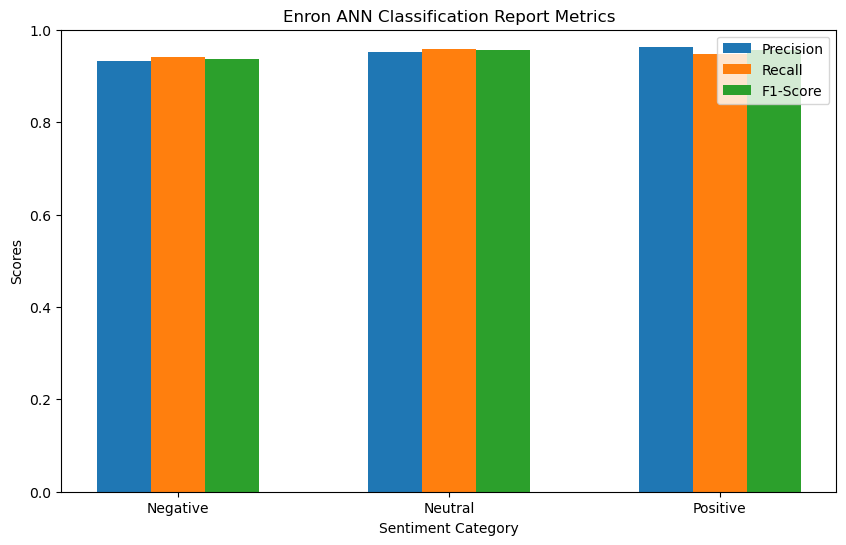

CPU times: total: 15min 28s
Wall time: 2min 40s


In [4]:
%%time

# ANN Neural Network.

X = data['processed_message']
y = data['vader_sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Define the improved ANN model
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

ann.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = ann.fit(X_train_vec, y_train, epochs=30, batch_size=256, validation_split=0.1, callbacks=[early_stopping])

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()

loss, accuracyANN = ann.evaluate(X_test_vec, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracyANN}")
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Predict the sentiment classes for the test set
y_pred_prob = ann.predict(X_test_vec)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Enron ANN Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.legend()

plt.ylim(0, 1.0)

plt.savefig(outputDir + '\\Enron\\EnronANN.png')

plt.show()

In [ ]:
import gc
gc.collect()

## Enron RNN Network Classification

In [ ]:
%%time

#RNN Neural Network

X = data['processed_message']
y = data['vader_sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),  # Add a new dimension
    tf.keras.layers.SimpleRNN(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    tf.keras.layers.Dense(3, activation='softmax')
])

model_rnn.compile('adam', 
                  'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_rnn.summary()


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(X_train_vec, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()

# Evaluate the model on test data
loss, accuracyRNN = model_rnn.evaluate(X_test_vec, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracyRNN}")
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Predict the sentiment classes for the test set
y_pred_prob = model_rnn.predict(X_test_vec)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Enron RNN Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.0)
plt.legend()

plt.savefig(outputDir + '\\Enron\\EnronRNN.png')

plt.show()

## Enron Traditional Classifiers Accuracy Score Evaluation

In [ ]:
# Accuracy scores
accuracy_scores = [lrAccEnron,
                   naive_bayesAccEnron,
                   svmAccEnron,
                   dtcAccEnron]

# Models
models = ['Logistic Regression', 'Naïve Bayes', 'SVM', 'Decision Tree']

# Plotting the horizontal bar graph
plt.barh(models, accuracy_scores, color='red')

# Adding values as annotations
for index, value in enumerate(accuracy_scores):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores of Different Traditional Classification Models on the Enron Dataset')
plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores
plt.savefig(outputDir + '\\Enron\\EnronMLAcc.png', bbox_inches = 'tight')
plt.show()

## Enron Neural Networks Accuracy Score Evaluation

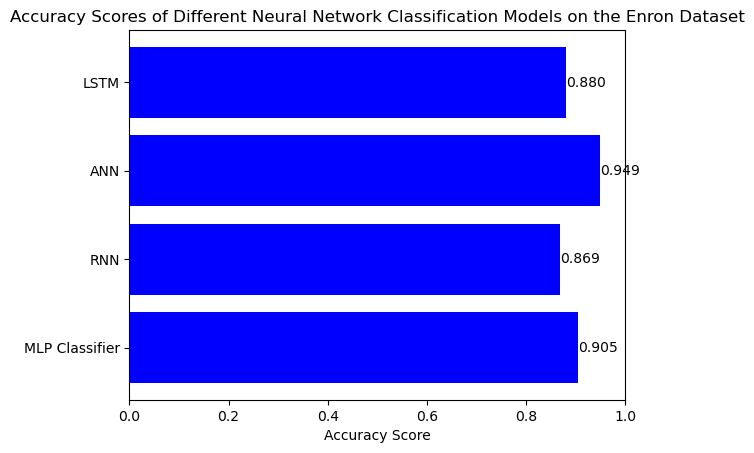

In [61]:
# Accuracy scores
# accuracy_scores = [mlpAcc,
#                    accuracyRNN,
#                    accuracyANN,
#                    accuracyLSTM]

accuracy_scores = [0.905,
                   0.869,
                   0.949,
                   0.88]

# Models
models = ['MLP Classifier', 'RNN', 'ANN', 'LSTM']

# Plotting the horizontal bar graph
plt.barh(models, accuracy_scores, color='blue')

# Adding values as annotations
for index, value in enumerate(accuracy_scores):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores of Different Neural Network Classification Models on the Enron Dataset')
plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores
plt.savefig(outputDir + '\\Enron\\EnronNNAcc.png', bbox_inches = 'tight')
plt.show()

# Labelled Twitter Dataset

## Importing the dataset and balancing the number of rows for each category.

In [6]:
dataset = pd.read_csv("./Datasets/train.csv",encoding='latin1')

print("Compiling final dataset...", end =" "),
dataset = dataset[['text', 'sentiment']]
print("done!")

dataset = dataset.dropna(subset=['text'])
dataset = dataset.dropna(subset=['sentiment'])

# Strip leading and trailing whitespace from the text column
dataset['text'] = dataset['text'].str.strip()

difference = 7000
# difference = 9000

# Calculating extra rows to be removed.
posDiff = (dataset[dataset.sentiment == 'positive'].shape[0]) - difference
negDiff = (dataset[dataset.sentiment == 'negative'].shape[0]) - difference
neuDiff = (dataset[dataset.sentiment == 'neutral'].shape[0]) - difference

print("Twitter Neutral Sentiment entries : ", dataset[dataset.sentiment == 'neutral'].shape[0], " rows, with ", neuDiff, " rows to remove.")
print("Twitter Positive Sentiment entries: ", dataset[dataset.sentiment == 'positive'].shape[0], "rows, with ", posDiff, " rows to remove.")
print("Twitter Negative Sentiment entries: ", dataset[dataset.sentiment == 'negative'].shape[0], "rows, with ", negDiff, " rows to remove.")

# Function to drop rows based on sorted index
def drop_excess_rows(df, sentiment, excess_count):
    if excess_count > 0:
        # Sort the DataFrame by index
        sorted_df = df[df['sentiment'] == sentiment].sort_index()
        # Drop the excess rows
        df = df.drop(sorted_df.index[:excess_count])
    return df

# Remove extra rows for each sentiment category
dataset = drop_excess_rows(dataset, 'neutral', neuDiff)
dataset = drop_excess_rows(dataset, 'positive', posDiff)
dataset = drop_excess_rows(dataset, 'negative', negDiff)

print("Updated Twitter Neutral Sentiment entries : ", dataset[dataset.sentiment == 'neutral'].shape[0])
print("Updated Twitter Positive Sentiment entries: ", dataset[dataset.sentiment == 'positive'].shape[0])
print("Updated Twitter Negative Sentiment entries: ", dataset[dataset.sentiment == 'negative'].shape[0])

Compiling final dataset... done!
Twitter Neutral Sentiment entries :  11117  rows, with  4117  rows to remove.
Twitter Positive Sentiment entries:  8582 rows, with  1582  rows to remove.
Twitter Negative Sentiment entries:  7781 rows, with  781  rows to remove.
Updated Twitter Neutral Sentiment entries :  7000
Updated Twitter Positive Sentiment entries:  7000
Updated Twitter Negative Sentiment entries:  7000


## Data Cleaning

In [7]:
features = dataset['text'].values
labels = dataset['sentiment'].values

processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

# processed_features

## Vectorization and splitting the dataset into training and test sets

In [8]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

## Twitter Logistic Regression

In [ ]:
%%time

text_classifier = LogisticRegression()
text_classifier.fit(X_train, y_train)
lr_predictions = text_classifier.predict(X_test)
classificationReport = classification_report(y_test,lr_predictions)
lrAcc = accuracy_score(y_test, lr_predictions)

print(classificationReport)
print("Accuracy score: ", lrAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision21 = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
recall21 = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
f1_score21 = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision21, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall21, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score21, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter Logistic Regression Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterLR.png')

plt.show()

## Twitter Naive Bayes Multinomial Classifier

In [ ]:
%%time

text_classifier = naive_bayes.MultinomialNB()
text_classifier.fit(X_train, y_train)
nb_predictions = text_classifier.predict(X_test)
classificationReport = classification_report(y_test,nb_predictions)
naive_bayesAcc = accuracy_score(y_test, nb_predictions)

print(classificationReport)
print("Accuracy score: ", naive_bayesAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision22 = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
recall22 = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
f1_score22 = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision22, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall22, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score22, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter Naive Bayes Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterNaiveBayes.png')

plt.show()

## Twitter Support Vector Machine Classifier

In [ ]:
%%time

text_classifier = svm.SVC(kernel='linear')
text_classifier.fit(X_train, y_train)
svm_predictions = text_classifier.predict(X_test)
classificationReport = classification_report(y_test,svm_predictions)
svmAcc = accuracy_score(y_test, svm_predictions)

print(classificationReport)
print("Accuracy score: ", svmAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision23 = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
recall23 = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
f1_score23 = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision23, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall23, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score23, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter SVM Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterSVM.png')

plt.show()

## Twitter Desicion Tree Classifier

In [ ]:
%%time

text_classifier = DecisionTreeClassifier()
text_classifier.fit(X_train, y_train)
dt_predictions = text_classifier.predict(X_test)
classificationReport = classification_report(y_test,dt_predictions)
dtcAcc = accuracy_score(y_test, dt_predictions)

print(classificationReport)
print("Accuracy score: ", dtcAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision24 = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
recall24 = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
f1_score24 = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))

ax.bar(bar_positions, precision24, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall24, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score24, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter Decision Tree Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterDTC.png')

plt.show()

# Twitter Neural Network Classification Models

## Twitter MLP Network Classification

In [ ]:
%%time

X = dataset['text']
y = dataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
X_test_tfidf = tfidf_vectorizer.transform(X_test.values.astype('U'))

# Initialize MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(200, 100),
                        activation='relu',  # Activation function for hidden layers
                        solver='adam',  # Optimization algorithm
                        max_iter=200,  # Maximum number of iterations
                        random_state=42)

mlp_clf.fit(X_train_tfidf, y_train)

# Evaluating the Model
y_pred = mlp_clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)

predictions = mlp_clf.predict(X_test_tfidf)

# Generate the classification report
report25 = classification_report(y_test, predictions)
print(report25)

# Compute accuracy
mlpAcc = accuracy_score(y_test, predictions)
print("MLP Classification Accuracy Score: ", mlpAcc)
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Extract precision, recall, and f1-score from the classification report
precision25 = [float(x.split()[1]) for x in report25.split('\n')[2:5]]
recall25 = [float(x.split()[2]) for x in report25.split('\n')[2:5]]
f1_score25 = [float(x.split()[3]) for x in report25.split('\n')[2:5]]

# Sentiment classes
sentiments = list(target_numbers.keys())

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plt.ylim(0, 1.0)

bar_width = 0.2
bar_positions = range(len(sentiments))
ax.bar(bar_positions, precision25, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall25, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score25, width=bar_width, label='F1-Score')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter MLP Classification Report Metrics')
plt.ylim(0, 1.0)
ax.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterMLP.png')

plt.show()

In [ ]:
import gc
gc.collect() 

## Twitter LSTM Network Classification

In [ ]:
%%time

# LSTM Neural Network.
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

X = dataset['text']
y = dataset['sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

# Reshape data for LSTM
max_features = X_train_vec.shape[1]
maxlen = X_train_vec.shape[0]

X_train_lstm = X_train_vec.reshape(maxlen, 1, max_features)
X_test_lstm = X_test_vec.reshape(X_test_vec.shape[0], 1, max_features)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Best layers so far.
model = Sequential()
model.add(LSTM(64, input_shape=(1, max_features))),
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
model.add(Dropout(0.5)),
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
model.add(Dropout(0.5)),
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
# Best parameters so far.
# history = model.fit(X_train_lstm, y_train_onehot, batch_size=64, epochs=20, 
#                     validation_split=0.1, callbacks=[early_stopping])

history = model.fit(X_train_lstm, y_train_onehot, batch_size=100, epochs=20, 
                    validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracyLSTM = model.evaluate(X_test_lstm, y_test_onehot)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()

# Predict the sentiment classes for the test set
y_pred_prob = model.predict(X_test_lstm)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Twitter LSTM Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.0)
plt.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterLSTM.png')

plt.show()

## Twitter ANN Classification

D:\Anaconda Download\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_142 (Dense)                    │ (None, 256)                 │       1,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,313,539 (5.01 MB)

 Trainable params: 1,313,539 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5118 - loss: 2.0509 - val_accuracy: 0.6625 - val_loss: 1.1166
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6605 - loss: 1.1214 - val_accuracy: 0.6804 - val_loss: 1.0972
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6793 - loss: 1.0731 - val_accuracy: 0.6667 - val_loss: 1.0771
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6947 - loss: 1.0369 - val_accuracy: 0.6696 - val_loss: 1.0666
Epoch 5/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7094 - loss: 1.0194 - val_accuracy: 0.6893 - val_loss: 1.0553
Epoch 6/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7168 - loss: 0.9951 - val_accuracy: 0.6643 - val_loss: 1.0573
Epoch 7/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7219 - loss: 0.9830 - val_accuracy: 0.6851 - val_loss: 1.0605
Epoch 8/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7291 - loss: 0.9777 - val_accuracy: 0.

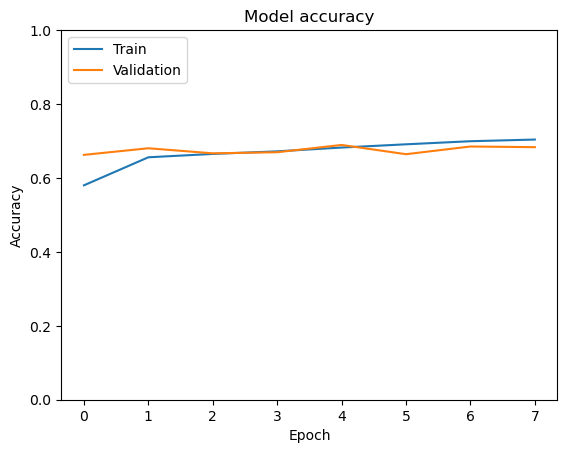

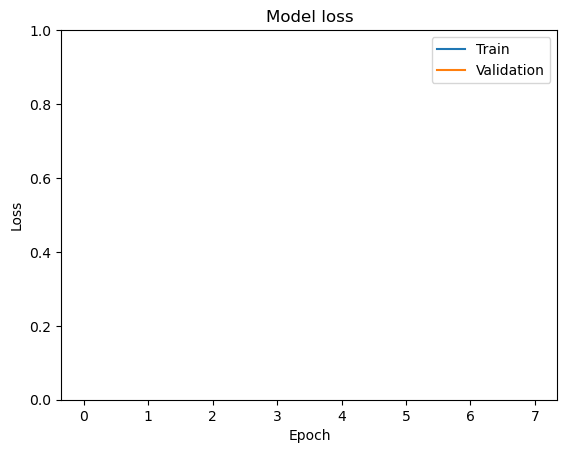

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6652 - loss: 1.0667
Test Loss: 1.0739998817443848
Test Accuracy: 0.6702380776405334
CPU Load     :  1.5
RAM Used (GB): 16.923475968
RSS (Resident Set Size) Memory Used by Process: 7614.59 MB
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    negative       0.74      0.62      0.68      1445
     neutral       0.57      0.61      0.59      1379
    positive       0.72      0.78      0.75      1376

    accuracy                           0.67      4200
   macro avg       0.67      0.67      0.67      4200
weighted avg       0.67      0.67      0.67      4200



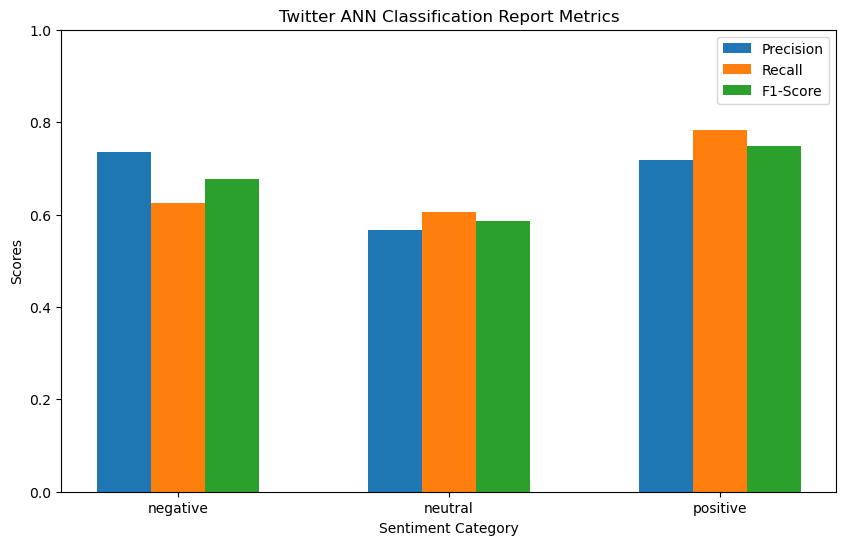

CPU times: total: 4 s
Wall time: 20.1 s


In [60]:
%%time

# ANN Neural Network.

X = dataset['text']
y = dataset['sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# vectorizer = TfidfVectorizer()
# X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
# X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

# ann = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output neurons based on number of classes
# ])

# ann.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# ann.summary()

# history = ann.fit(X_train_vec, y_train, epochs=20, batch_size=100, validation_split=0.1)

# Initialize CountVectorizer with desired parameters
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2), max_df=0.95, min_df=2)

# Fit and transform on training data
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()

# Transform test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

# Model definition
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ann.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

ann.summary()

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = ann.fit(X_train_vec, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()

loss, accuracyANN = ann.evaluate(X_test_vec, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracyANN}")
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Predict the sentiment classes for the test set
y_pred_prob = ann.predict(X_test_vec)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Twitter ANN Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.0)
plt.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterANN.png')

plt.show()

In [59]:
import gc
gc.collect()

0

## Twitter RNN Classification

In [ ]:
%%time

# RNN Neural Network

X = dataset['text']
y = dataset['sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Define the model
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),  # Add a new dimension
    tf.keras.layers.SimpleRNN(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduce the size of the RNN layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Define the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the custom optimizer
model_rnn.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

model_rnn.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(X_train_vec, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1.0)
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(0, 1.0)
plt.show()

# Evaluate the model on test data
loss, accuracyRNN = model_rnn.evaluate(X_test_vec, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracyRNN}")
print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
print_memory_usage()

# Predict the sentiment classes for the test set
y_pred_prob = model_rnn.predict(X_test_vec)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Twitter RNN Classification Report Metrics')
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.0)
plt.legend()

plt.savefig(outputDir + '\\Twitter\\TwitterRNN.png')

plt.show()

In [ ]:
def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"RSS (Resident Set Size) Memory Used by Process: {mem_info.rss / 1024 ** 2:.2f} MB")
    
import gc
gc.collect()  

In [ ]:
# Accuracy scores
accuracy_scores = [lrAcc,
                   naive_bayesAcc,
                   svmAcc,
                   dtcAcc]

# Models
models = ['SVM', 'Logistic Regression', 'Naïve Bayes', 'Decision Tree']

# Plotting the horizontal bar graph
plt.barh(models, accuracy_scores, color='red')

# Adding values as annotations
for index, value in enumerate(accuracy_scores):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores of Different Traditional Classification Models on the Twitter Dataset')
plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores
plt.savefig(outputDir + '\\Twitter\\TwitterMLAcc.png', bbox_inches = 'tight')
plt.show()

In [ ]:
# Accuracy scores
accuracy_scores = [mlpAcc,
                   accuracyRNN,
                   accuracyANN,
                   accuracyLSTM]

# Models
models = ['MLP Classifier', 'RNN', 'ANN', 'LSTM']

# Plotting the horizontal bar graph
plt.barh(models, accuracy_scores, color='blue')

# Adding values as annotations
for index, value in enumerate(accuracy_scores):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores of Different Neural Network Classification Models on the Twitter Dataset')
plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores
plt.savefig(outputDir + '\\Twitter\\TwitterNNAcc.png', bbox_inches = 'tight')
plt.show()

# Labelled Twitter 2 Dataset

In [ ]:
# dataset = pd.read_csv("Datasets/twitter.csv", encoding='unicode_escape')
# print(dataset.info())
# print(dataset.head())

## Applying helper function for even data distribution

In [ ]:
# # Rename the column from 'Category' to 'sentiment'
# dataset.rename(columns={'category': 'sentiment'}, inplace=True)

# # Map the values in the 'sentiment' column using the mapping dictionary
# dataset['sentiment'] = dataset['sentiment'].map({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})

## Data Cleaning

In [ ]:
# features = dataset['clean_text'].values
# labels = dataset['sentiment'].values

# processed_features = []

# for sentence in range(0, len(features)):
#     # Remove all the special characters
#     processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

#     # remove all single characters
#     processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

#     # Remove single characters from the start
#     processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

#     # Substituting multiple spaces with single space
#     processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

#     # Removing prefixed 'b'
#     processed_feature = re.sub(r'^b\s+', '', processed_feature)

#     # Converting to Lowercase
#     processed_feature = processed_feature.lower()

#     processed_features.append(processed_feature)

# # processed_features

## Vectorization and splitting the dataset into training and test sets

In [ ]:
# vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
# processed_features = vectorizer.fit_transform(processed_features).toarray()
# X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

## Twitter 2 Logistic Regression

In [ ]:
# %%time

# text_classifier = LogisticRegression()
# text_classifier.fit(X_train, y_train)
# lr_predictions = text_classifier.predict(X_test)
# classificationReport = classification_report(y_test,lr_predictions)
# lrAcc2 = accuracy_score(y_test, lr_predictions)

# print(classificationReport)
# print("Accuracy score: ", lrAcc2)

# # Extract precision, recall, and f1-score from the classification report
# precision = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
# recall = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
# f1_score = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# # Sentiment classes
# sentiments = list(target_numbers.keys())

# # Plotting the bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# bar_width = 0.2
# bar_positions = range(len(sentiments))

# ax.bar(bar_positions, precision, width=bar_width, label='Precision')
# ax.bar([pos + bar_width for pos in bar_positions], recall, width=bar_width, label='Recall')
# ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score, width=bar_width, label='F1-Score')

# ax.set_xticks([pos + bar_width for pos in bar_positions])
# ax.set_xticklabels(sentiments)

# ax.set_xlabel('Sentiment')
# ax.set_ylabel('Score')
# ax.set_title('Classification Report Metrics')
# ax.legend()

# plt.show()

## Twitter 2 Naive Bayes Multinomial Classifier

In [ ]:
# %%time

# text_classifier = naive_bayes.MultinomialNB()
# text_classifier.fit(X_train, y_train)
# nb_predictions = text_classifier.predict(X_test)
# classificationReport = classification_report(y_test,nb_predictions)
# naive_bayesAcc2 = accuracy_score(y_test, nb_predictions)

# print(classificationReport)
# print("Accuracy score: ", naive_bayesAcc2)

# # Extract precision, recall, and f1-score from the classification report
# precision = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
# recall = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
# f1_score = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# # Sentiment classes
# sentiments = list(target_numbers.keys())

# # Plotting the bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# bar_width = 0.2
# bar_positions = range(len(sentiments))

# ax.bar(bar_positions, precision, width=bar_width, label='Precision')
# ax.bar([pos + bar_width for pos in bar_positions], recall, width=bar_width, label='Recall')
# ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score, width=bar_width, label='F1-Score')

# ax.set_xticks([pos + bar_width for pos in bar_positions])
# ax.set_xticklabels(sentiments)

# ax.set_xlabel('Sentiment')
# ax.set_ylabel('Score')
# ax.set_title('Classification Report Metrics')
# ax.legend()

# plt.show()

## Twitter 2 Support Vector Machine Classifier

In [ ]:
# %%time

# text_classifier = svm.SVC(kernel='linear')
# text_classifier.fit(X_train, y_train)
# svm_predictions = text_classifier.predict(X_test)
# classificationReport = classification_report(y_test,svm_predictions)
# svmAcc2 = accuracy_score(y_test, svm_predictions)

# print(classificationReport)
# print("Accuracy score: ", svmAcc2)

# # Extract precision, recall, and f1-score from the classification report
# precision = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
# recall = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
# f1_score = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# # Sentiment classes
# sentiments = list(target_numbers.keys())

# # Plotting the bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# bar_width = 0.2
# bar_positions = range(len(sentiments))

# ax.bar(bar_positions, precision, width=bar_width, label='Precision')
# ax.bar([pos + bar_width for pos in bar_positions], recall, width=bar_width, label='Recall')
# ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score, width=bar_width, label='F1-Score')

# ax.set_xticks([pos + bar_width for pos in bar_positions])
# ax.set_xticklabels(sentiments)

# ax.set_xlabel('Sentiment')
# ax.set_ylabel('Score')
# ax.set_title('Classification Report Metrics')
# ax.legend()

# plt.show()

## Twitter 2 Desicion Tree Classifier

In [ ]:
# %%time

# text_classifier = DecisionTreeClassifier()
# text_classifier.fit(X_train, y_train)
# dt_predictions = text_classifier.predict(X_test)
# classificationReport = classification_report(y_test,dt_predictions)
# dtcAcc2 = accuracy_score(y_test, dt_predictions)

# print(classificationReport)
# print("Accuracy score: ", dtcAcc2)

# # Extract precision, recall, and f1-score from the classification report
# precision = [float(x.split()[1]) for x in classificationReport.split('\n')[2:5]]
# recall = [float(x.split()[2]) for x in classificationReport.split('\n')[2:5]]
# f1_score = [float(x.split()[3]) for x in classificationReport.split('\n')[2:5]]

# # Sentiment classes
# sentiments = list(target_numbers.keys())

# # Plotting the bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# bar_width = 0.2
# bar_positions = range(len(sentiments))

# ax.bar(bar_positions, precision, width=bar_width, label='Precision')
# ax.bar([pos + bar_width for pos in bar_positions], recall, width=bar_width, label='Recall')
# ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score, width=bar_width, label='F1-Score')

# ax.set_xticks([pos + bar_width for pos in bar_positions])
# ax.set_xticklabels(sentiments)

# ax.set_xlabel('Sentiment')
# ax.set_ylabel('Score')
# ax.set_title('Classification Report Metrics')
# ax.legend()

# plt.show()

## Accuracy Score Evaluation

In [ ]:
# # Accuracy scores
# accuracy_scores = [lrAcc,
#                    naive_bayesAcc,
#                    svmAcc,
#                    dtcAcc]

# # Models
# models = ['SVM', 'Logistic Regression', 'Naïve Bayes', 'Decision Tree']

# # Plotting the horizontal bar graph
# plt.barh(models, accuracy_scores, color='red')

# # Adding values as annotations
# for index, value in enumerate(accuracy_scores):
#     plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
# plt.xlabel('Accuracy Score')
# plt.title('Accuracy Scores of Different Models')
# plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores
# plt.show()

## Accuracy Score Evaluation of all the classification algorithms for all datasets.

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(16,6))

# # Plot 1
# plt.subplot(1, 2, 1)

# # Accuracy scores for Twitter Dataset
# accuracy_scores_twitter = [accuracy_score(y_test, svm_predictions),
#                            accuracy_score(y_test, lr_predictions),
#                            accuracy_score(y_test, nb_predictions),
#                            accuracy_score(y_test, dt_predictions)]

# # Models
# models_twitter = ['SVM', 'Logistic Regression', 'Naïve Bayes', 'Decision Tree']

# # Plotting the horizontal bar graph for Twitter Dataset
# plt.barh(models_twitter, accuracy_scores_twitter, color='skyblue')

# # Adding values as annotations
# for index, value in enumerate(accuracy_scores_twitter):
#     plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
# plt.xlabel('Accuracy Score')
# plt.title('Accuracy Scores of the different classification models for the Twitter Dataset')
# plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores

# # Plot 2
# plt.subplot(1, 2, 2)

# # Accuracy scores for Enron Dataset
# accuracy_scores_enron = [svmAccEnron,
#                          lrAccEnron,
#                          naive_bayesAccEnron,
#                          dtcAccEnron]

# # Models
# models_enron = ['SVM', 'Logistic Regression', 'Naïve Bayes', 'Decision Tree']

# # Plotting the horizontal bar graph for Enron Dataset
# plt.barh(models_enron, accuracy_scores_enron, color='red')

# # Adding values as annotations
# for index, value in enumerate(accuracy_scores_enron):
#     plt.text(value, index, f'{value:.3f}', ha='left', va='center')
    
# plt.xlabel('Accuracy Score')
# plt.title('Accuracy Scores of Different Models for the Enron Dataset')
# plt.xlim(0, 1)  # Set the x-axis limit to the range [0, 1] for accuracy scores

# # Adjust layout
# plt.tight_layout()

# plt.savefig(outputDir + '\\AllClassifiersAccuracies.png')

# # Show the plot
# plt.show()

# #------------------------------------------------------------------------------------------------------------------------

# print('\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Classification Values for the Enron Dataset classifiers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')



# Load the saved plots
plot_pathsEnron = [outputDir + '\\Enron\\EnronDTC.png', outputDir + '\\Enron\\EnronLogisticRegression.png', outputDir + '\\Enron\\EnronNaiveBayes.png', outputDir + '\\Enron\\EnronSVM.png']
plot_pathsTwitter = [outputDir + 'Twitter\\TwitterDTC.png', outputDir + 'Twitter\\TwitterLR.png', outputDir + 'Twitter\\TwitterNaiveBayes.png', outputDir + 'Twitter\\TwitterSVM.png']

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed

# Plot 1
ax = axs[0, 0]
bar_width = 0.2
bar_positions = range(len(sentiments))
bars_precision = ax.bar(bar_positions, precision11, width=bar_width, label='Precision')
bars_recall = ax.bar([pos + bar_width for pos in bar_positions], recall11, width=bar_width, label='Recall')
bars_f1_score = ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score11, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Logistic Regression Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars_precision, precision11):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_recall, recall11):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_f1_score, f1_score11):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

# Legend outside the plot
ax.legend(bbox_to_anchor=(-0.5, 1.1), loc=2, borderaxespad=4.7)


# Plot 2
ax = axs[0, 1]
bar_positions = range(len(sentiments))
bars_precision = ax.bar(bar_positions, precision12, width=bar_width, label='Precision')
bars_recall = ax.bar([pos + bar_width for pos in bar_positions], recall12, width=bar_width, label='Recall')
bars_f1_score = ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score12, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_title('Enron Naive Bayes Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars_precision, precision12):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_recall, recall12):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_f1_score, f1_score12):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')



# Plot 3
ax = axs[1, 0]
bar_positions = range(len(sentiments))
bars_precision = ax.bar(bar_positions, precision13, width=bar_width, label='Precision')
bars_recall = ax.bar([pos + bar_width for pos in bar_positions], recall13, width=bar_width, label='Recall')
bars_f1_score = ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score13, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Enron Decision Tree Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars_precision, precision13):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_recall, recall13):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_f1_score, f1_score13):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')
    
ax.legend(bbox_to_anchor=(-0.5, 1.1), loc=2, borderaxespad=4.7)



# Plot 4
ax = axs[1, 1]
bar_positions = range(len(sentiments))
bars_precision = ax.bar(bar_positions, precision14, width=bar_width, label='Precision')
bars_recall = ax.bar([pos + bar_width for pos in bar_positions], recall14, width=bar_width, label='Recall')
bars_f1_score = ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score14, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_title('Enron SVM Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars_precision, precision14):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_recall, recall14):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(bars_f1_score, f1_score14):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height()+ 0.01, f'{value:.3f}', ha='left', va='bottom')

plt.savefig(outputDir + '\\Enron\\EnronAllClassifiers.png')

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()


print('\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Classification Values for the Twitter Dataset classifiers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed

# Plot 1
ax = axs[0, 0]
bars = ax.bar(bar_positions, precision21, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall21, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score21, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter Logistic Regression Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars, precision21):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

# Adding values for recall and F1-score
for bar, value in zip(ax.containers[1], recall21):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(ax.containers[2], f1_score21):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

# Legend outside the plot
ax.legend(bbox_to_anchor=(-0.5, 1.1), loc=2, borderaxespad=4.7)


# Plot 2
ax = axs[0, 1]
bars = ax.bar(bar_positions, precision22, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall22, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score22, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_title('Twitter Naive Bayes Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars, precision22):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

# Adding values for recall and F1-score
for bar, value in zip(ax.containers[1], recall22):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(ax.containers[2], f1_score22):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')


# Plot 3
ax = axs[1, 0]
bars = ax.bar(bar_positions, precision23, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall23, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score23, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Twitter SVM Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars, precision23):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

# Adding values for recall and F1-score
for bar, value in zip(ax.containers[1], recall23):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(ax.containers[2], f1_score23):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

ax.legend(bbox_to_anchor=(-0.5, 1.1), loc=2, borderaxespad=4.7)


# Plot 4
ax = axs[1, 1]
bars = ax.bar(bar_positions, precision24, width=bar_width, label='Precision')
ax.bar([pos + bar_width for pos in bar_positions], recall24, width=bar_width, label='Recall')
ax.bar([pos + 2 * bar_width for pos in bar_positions], f1_score24, width=bar_width, label='F1-Score')
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(sentiments)
ax.set_xlabel('Sentiment')
ax.set_title('Twitter Decision Tree Classification Report Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 0-1

# Adding values as annotations next to the bars
for bar, value in zip(bars, precision24):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

# Adding values for recall and F1-score
for bar, value in zip(ax.containers[1], recall24):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

for bar, value in zip(ax.containers[2], f1_score24):
    ax.text(bar.get_x() + bar.get_width(), bar.get_height(), f'{value:.3f}', ha='left', va='bottom')

plt.savefig(outputDir + '\\Twitter\\TwitterAllClassifiers.png')

# # Adjust layout
plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

end = datetime.datetime.now()
duration = end-start
print("Total program execution time: ", duration)
gc.collect()